# <b>GOAL</b>: Train and Tune ML Models to predict Salary outputs from Features

# Table of contents | Summary
1. [<i>Import</i> Libraries](#libs)
2. [<i>Load</i> TRAIN, VALID, & TEST data](#load)
3. [<i>Create</i> Helper Functions](#helpers)
4. [*Implement* and *score* models: **loss, visualize feature weights, and save model(.pkl)**](#fitscore)
    - [Linear Regression](#lr)
    - [Random Forest](#rf)
    - [Gradient Boosting Regressor](#gbr)
    - [XGBR](#xgbr)
5. [<i>Store</i> Base Model scores](#base)

## 1. <i>Import</i> Libraries <a name = "libs"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

import pickle
import eli5
import re

import warnings
warnings.filterwarnings('ignore', category= DeprecationWarning)

__author__ = "Sid Vanam"
__email__ = "vanamsid@gmail.com"

/Users/vanamsid/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/vanamsid/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## 2. <i>Load</i> TRAIN, VALID, & TEST data <a name = "load">

In [2]:
'''Read Train Data'''
with open('../salary prediction data/Pickle Data/TRAIN_X.pkl', 'rb') as temp0:
    X_train = pickle.load(temp0)
with open('../salary prediction data/Pickle Data/TRAIN_Y.pkl', 'rb') as temp1:
    y_train = pickle.load(temp1)

In [3]:
'''Read Validation Data'''
with open('../salary prediction data/Pickle Data/VALID_X.pkl', 'rb') as temp2:
    X_valid = pickle.load(temp2)
with open('../salary prediction data/Pickle Data/VALID_Y.pkl', 'rb') as temp3:
    y_valid = pickle.load(temp3)

In [4]:
'''Read Test Data'''
with open('../salary prediction data/Pickle Data/TEST_X.pkl', 'rb') as temp4:
    X_test = pickle.load(temp4)
with open('../salary prediction data/Pickle Data/TEST_Y.pkl', 'rb') as temp5:
    y_test = pickle.load(temp5)

## 3. <i>Create</i> Helper Functions <a name= "helpers">

In [5]:
def fitscore_model(model, kind = 'rf'):
    ''' Returns a Mean Squared Error Score based on the VALIDation data'''
    
    if kind == 'xgbr':
        model.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric = 'mean_squared_error', verbose = False)
        predictions = model.predict(X_valid)
        error = mean_squared_error(predictions, y_valid)
        print('loss: ' + str(-1*error))
        return error
    else:
        model.fit(X_train, y_train)
        predictions = model.predict(X_valid)
        error = mean_squared_error(predictions, y_valid)
        print('loss: ' + str(-1*error))
        return error

In [6]:
def find_top_features(model, positive = True):
    '''Returns a table that replaces eli5.show_weights table with ACTUAL feature names'''
    
    table = eli5.explain_weights_df(model)[['feature', 'weight']]  #returns a df
    
    if type(model).__name__ == 'LinearRegression':
        #Find and drop index for <BIAS> row
        drop_index = table.feature[table.feature == '<BIAS>'].index[0]
        table = table.drop(drop_index, axis = 0)
        
        #Strip the 'x' from the feature column to later find the index of each feature column
        stripped= [int(re.split('x', feature)[1]) for feature in table.feature]
        indices = [num for num in stripped]
        
         #Creates a list of the features that correspond to the eli5 indices
        table['feature'] = [X_train.columns[i] for i in indices]
        
        if positive:
            return table.loc[table.weight > 0]
        elif positive == False:
            return table.loc[table.weight < 0].reset_index().drop('index', axis = 1)
    
    elif type(model).__name__ == 'RandomForestRegressor':
        #Strip the 'x' from the feature column to later find the index of each feature column
        stripped= [int(re.split('x', feature)[1]) for feature in table.feature]
        indices = [num for num in stripped]
        
         #Creates a list of the features that correspond to the eli5 indices
        table['feature'] = [X_train.columns[i] for i in indices]
        return table
    
    elif type(model).__name__ == 'GradientBoostingRegressor':
        #Strip the 'x' from the feature column to later find the index of each feature column
        stripped= [int(re.split('x', feature)[1]) for feature in table.feature]
        indices = [num for num in stripped]
        
         #Creates a list of the features that correspond to the eli5 indices
        table['feature'] = [X_train.columns[i] for i in indices]
        return table
        
    elif type(model).__name__ == 'XGBRegressor':
        return table

In [7]:
def gen_palette():
# ''' Care about which categories are most represented in graphs -> create a dictionary that maps features: colors'''
    feature_list = X_train.columns.tolist()
    color_dict = {}
    for feature in feature_list:
        if 'jobType' in feature:
            color_dict[feature] = '#9BD770'  #jade -- green
        
        elif 'degree' in feature:
            color_dict[feature] = '#CB483B'  #daredevil -- red
        
        elif 'major' in feature:
            color_dict[feature] = '#FFC076'  #maize -- yellow
        
        elif 'industry' in feature:
            color_dict[feature] = '#81D1EC'  #ice -- blue
        
        else:
            color_dict[feature] = '#858D99'  #neutralbay -- grey
    return color_dict

def gen_legendpatch():
    '''Creates a patch with a dictionary for the visualization'''
    
    legend = {}
    legend['jobType'] = '#9BD770'
    legend['degree'] = '#CB483B'
    legend['major'] = '#FFC076'
    legend['industry'] = '#81D1EC'
    legend['numerical_categories'] = '#858D99'
    
    patches = [mpl.patches.Patch(label = k, color = v, ) for k,v in legend.items()]

    return patches

In [161]:
def show_values_on_bars(axs):
    '''Shows values for multi axes plots'''
    
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y+.25, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [188]:
def featureviz(model):
    '''Creates a visualization of feature importances for each model'''
   
    colors = gen_palette()
    patches = gen_legendpatch()

    sns.set_style('whitegrid')
    
    if type(model).__name__ == 'LinearRegression':
         #Create subplots for both +/- coefficients
        f, axes = plt.subplots(1, 2, figsize=(15, 7))
        f.suptitle('Comparing Positive vs. Negative Feature weights against Target Salary')
        
        for ax in f.axes:
            plt.sca(ax)
            plt.xticks(rotation=90)
            plt.legend(handles = patches, handlelength = 5, labelspacing = 0.75)
            plt.rcParams["axes.labelsize"] = 15


        #Create subtitles for each graph
        axes[0].set_title('Positive feature weights vs. Salary')
        axes[1].set_title('Negative feature weights vs. Salary')
        
        #Create positive and negative DataFrames
        pos_feats = find_top_features(model)
        neg_feats = find_top_features(model, False)
    
        sns.barplot(x = pos_feats['feature'], y = pos_feats['weight'], 
                    data= pos_feats, ax= axes[0], palette = colors)
        sns.barplot(x = neg_feats['feature'], y = neg_feats['weight'], 
                    data= neg_feats, ax= axes[1], palette = colors)

        show_values_on_bars(axes[0])
        show_values_on_bars(axes[1])
 
    else:
        f, axes = plt.subplots(1, 1, figsize=(15, 7))
        plt.sca(axes)
        plt.xticks(rotation=90)
        plt.legend(handles = patches, handlelength = 5, labelspacing = 0.75)
        plt.rcParams["axes.labelsize"] = 15

        
        model_name = str(type(model).__name__)        
        axes.set_title(model_name + "'s feature Weights vs. Salary", fontdict = {'fontsize' : 20})
        
        table = find_top_features(model)
        sns.barplot(x = table['feature'], y = table['weight'], data= table, ax= axes, palette = colors)
        
        for ticklabel in (axes.get_xticklabels()):
            ticklabel.set_fontsize(12)
        for ticklabel in (axes.get_yticklabels()):
            ticklabel.set_fontsize(12)
                
        # set individual bar labels
        for i in axes.patches:
            # get_x pulls left or right; get_height pushes up or down
            axes.text(i.get_x()+.13, i.get_height()+0.001, 
                      str(round((i.get_height()), 2)), fontsize=10, color='black')

## 4. *Implement* and *score* models <a name = "fitscore"></a>

- LinearRegression
- RandomForestRegressor
- Gradient Boosting Regressor
- XGBoost

In [10]:
lr = LinearRegression(n_jobs = -1)

In [11]:
rf = RandomForestRegressor(n_estimators= 50, n_jobs = -1, random_state= 42,
                           max_depth= 10, min_samples_split= 50)

In [12]:
gbr = GradientBoostingRegressor(n_estimators= 50, random_state= 42,
                           max_depth= 10, min_samples_split= 20)

In [13]:
xgbr = XGBRegressor(random_state= 42, n_jobs= -1) #insert 2nd model below this cell

### Linear Regression <a name = "lr"></a>

In [14]:
from sklearn.model_selection import cross_val_score

In [15]:
lr_score = fitscore_model(lr)
lr_score

loss: -384.6183843413881


384.6183843413881

In [17]:
eli5.show_weights(lr)

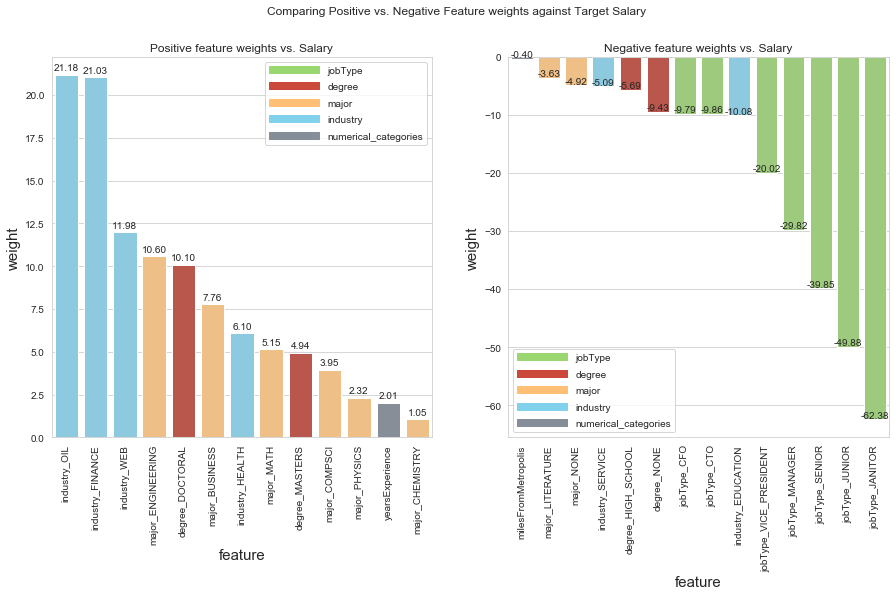

In [189]:
featureviz(lr)

**Summary:** Since this is a Linear Regression model, weights will be determined by which features added the **most signal** in predicting Salary.
<br> The **TOP 3 positive features** the model indentified were *all* (high-paying) "industries":</br>
- 'industry_Oil', 
- 'industry_Finance'
- 'industry_Web' 

<br>In contrast the **TOP 3 negative features** the model identified were *all* "jobTypes":</br>
- 'jobType_Janitor'
- 'jobType_Junior'
- 'jobType_Senior'

#### Save Linear Regression model in a Pickle file<a name = #picklelr>

In [19]:
with open('../salary prediction data/Base Models/base_lr.pkl', 'wb') as temp0:
    pickle.dump(lr, temp0)

### Random Forest Regressor model <a name = "rf"></a>

In [20]:
rf_score = fitscore_model(rf)
rf_score

loss: -470.91933948610205


470.91933948610205

In [22]:
eli5.show_weights(rf)

Weight,Feature
0.2888 ± 0.0022,x2
0.1932 ± 0.0021,x25
0.1305 ± 0.0020,x26
0.1057 ± 0.0015,x3
0.0779 ± 0.0010,x17
0.0701 ± 0.0010,x5
0.0412 ± 0.0023,x19
0.0392 ± 0.0008,x4
0.0282 ± 0.0027,x23
0.0084 ± 0.0022,x20


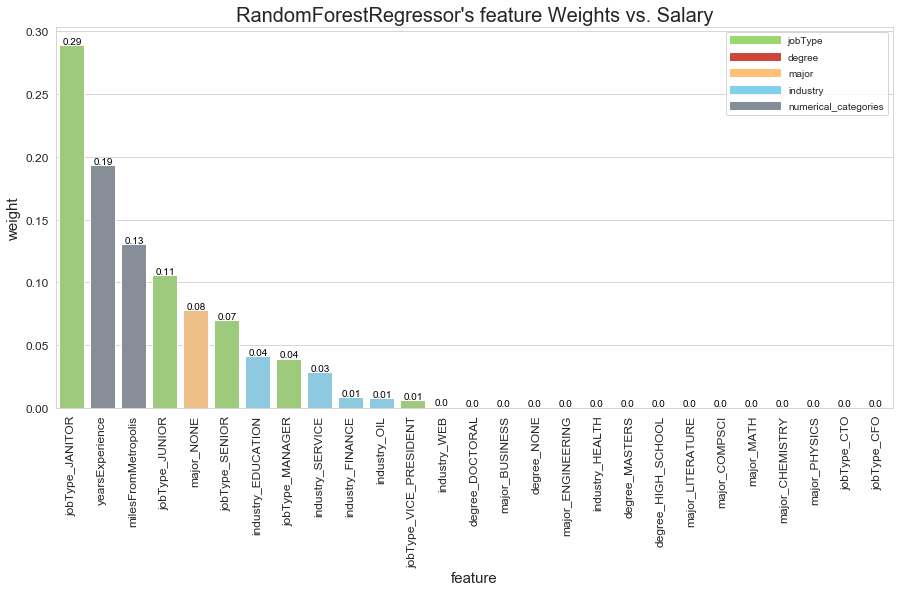

In [190]:
featureviz(rf)

**Summary:** Since this is a Random Forest regressor weights will be determined by which features added the **most signal** in predicting salary from its individual decision trees. <br>The model indentifies 4 features with strong predictive signal **(> 10% weight)** --**2** of which are **"jobType"** and **2** of which are **"numerical categories"**:
- 'jobType_Janitor'
- 'yearsExperience'
- 'milesFromMetropolis'
- 'jobType_junior'  


#### Save Random Forest model in a Pickle file<a name = #picklerf>

In [25]:
with open('../salary prediction data/Base Models/base_rf.pkl', 'wb') as temp1:
    pickle.dump(rf, temp1)

### Gradient Boosting model<a name = "gbr"></a>

In [26]:
gbr_score = fitscore_model(gbr)
gbr_score

loss: -362.08858833042245


362.08858833042245

In [28]:
eli5.show_weights(gbr)

Weight,Feature
0.2533 ± 0.1990,x2
0.1879 ± 0.0791,x25
0.1307 ± 0.0419,x26
0.0937 ± 0.0543,x3
0.0621 ± 0.0311,x5
0.0592 ± 0.0681,x17
0.0347 ± 0.0305,x4
0.0294 ± 0.0303,x19
0.0270 ± 0.0301,x20
0.0255 ± 0.0300,x22


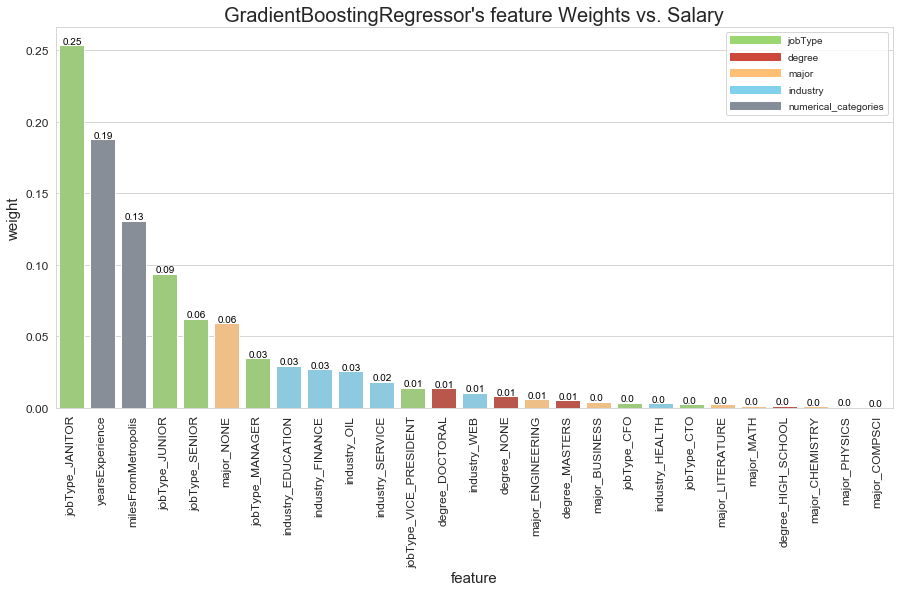

In [191]:
featureviz(gbr)

**Summary:** Since this is a Gradient boosting regressor it will use <i>Gradient Descent</i> to **minimize our loss function** -- MSE. <br>GBR indentified **'jobType_Janitor'and 'yearsExperience'** to provide strong signal(~>20% weight) in predicting Salary. The <i>majority</i> of the boosting predictors are 'jobType' and numerical features.

#### Save GBR model in a Pickle file<a name = #picklegbr>

In [31]:
with open('../salary prediction data/Base Models/base_gbr.pkl', 'wb') as temp2:
    pickle.dump(gbr, temp2)

### XGBoost model<a name = "xgbr"></a>

In [32]:
xgbr_score = fitscore_model(xgbr)
xgbr_score

[14:03:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
loss: -395.1828451344101


395.1828451344101

In [34]:
eli5.show_weights(xgbr)

Weight,Feature
0.2149,major_NONE
0.2007,jobType_JANITOR
0.0849,jobType_JUNIOR
0.0724,yearsExperience
0.0493,industry_SERVICE
0.0487,milesFromMetropolis
0.0432,jobType_SENIOR
0.0388,industry_OIL
0.0382,industry_EDUCATION
0.0337,jobType_CTO


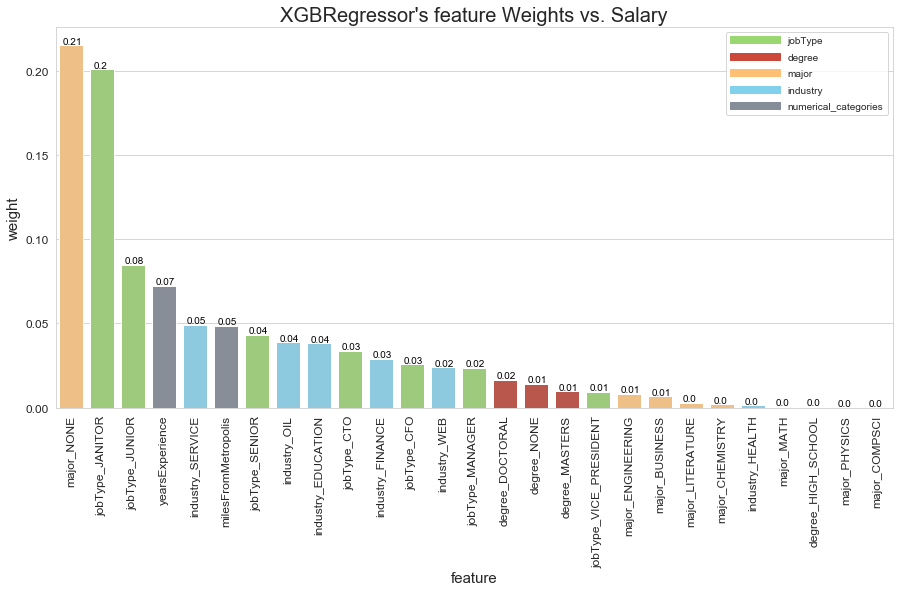

In [192]:
featureviz(xgbr)

**Summary:** Since this is a boosting regressor it will try to convert *weak* learners *into strong* ones. <br>XGBoost indentified **'major_none' and 'jobType_Janitor'** as providing weak signal, so the model tried boosting these features gain a better signal from them. Consequently **jobType_junior**, **yearsExperience**, **industry_service**, and **milesFromMetropolis** had >= 0.05 weight in predicting Salary.

#### Save XGBR model in a Pickle file<a name = #picklexgbr>

In [37]:
with open('../salary prediction data/Base Models/base_xgbr.pkl', 'wb') as temp3:
    pickle.dump(xgbr, temp3)

## 5. <i>Store</i> Base Model scores<a name = "base"></a>

In [38]:
model_names = ['LinearRegression', 'RandomForestRegressor', 'GradientBoostingRegressor', 'XGBRegressor']
model_scores = [lr_score, rf_score, gbr_score, xgbr_score]
model_dict = dict(zip(model_names, model_scores))

In [39]:
initial_scores = pd.Series(model_dict).sort_values(ascending= False)
initial_scores

RandomForestRegressor        470.919339
XGBRegressor                 395.182845
LinearRegression             384.618384
GradientBoostingRegressor    362.088588
dtype: float64

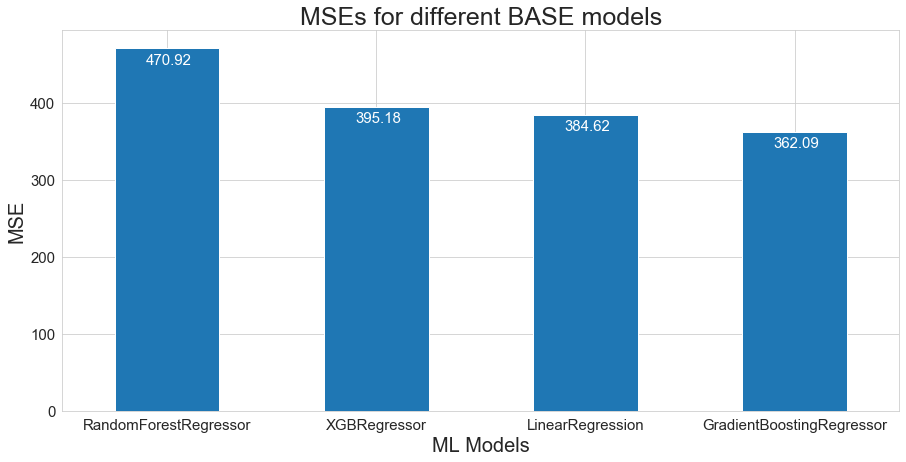

In [101]:
f, ax = plt.subplots(1, 1, figsize=(15, 7))
initial_scores.plot(kind = 'bar')
plt.title('MSEs for different BASE models', fontdict = {'fontsize' : 25})
plt.xlabel('ML Models', fontdict = {'fontsize' : 20})
plt.ylabel('MSE', fontdict = {'fontsize' : 20})

plt.xticks(rotation = 0)

# set individual bar labels
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-20, str(round((i.get_height()), 2)), fontsize=15, color='white')

#set size of x and y tick labels
for ticklabel in (ax.get_xticklabels()):
    ticklabel.set_fontsize(15)
for ticklabel in (ax.get_yticklabels()):
    ticklabel.set_fontsize(15)

**Summary:** GBR is the **BEST estimator** as it produces the lowest MSE, followed by the simple Linear Regression model - **the Random Forest Regressor performed considerably worse**.